In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [2]:
from zigzag import *

In [3]:
df = pd.read_csv('data\EURUSD.csv').iloc[:, 1:]
df['datetime'] = pd.to_datetime(df.loc[:,df.columns[2]])
df

,ticker,per,datetime,open,hight,low,close,volume
0,SPFB.ED,1,2009-06-15 19:52:00,1.3773,1.3773,1.3772,1.3772,4
1,SPFB.ED,1,2009-06-15 19:53:00,1.3766,1.3766,1.3760,1.3763,257
2,SPFB.ED,1,2009-06-15 19:56:00,1.3770,1.3770,1.3770,1.3770,100
3,SPFB.ED,1,2009-06-15 19:58:00,1.3769,1.3773,1.3769,1.3773,101
4,SPFB.ED,1,2009-06-15 20:00:00,1.3769,1.3769,1.3769,1.3769,6
...,...,...,...,...,...,...,...,...
2326809,SPFB.ED,1,2022-12-30 23:45:00,1.0417,1.0417,1.0416,1.0416,16
2326810,SPFB.ED,1,2022-12-30 23:46:00,1.0416,1.0417,1.0416,1.0417,21
2326811,SPFB.ED,1,2022-12-30 23:47:00,1.0416,1.0416,1.0415,1.0415,22
2326812,SPFB.ED,1,2022-12-30 23:48:00,1.0416,1.0417,1.0414,1.0417,29


In [4]:
df_close = df[['datetime', 'close']]
df_close.set_index(df_close.columns[0], inplace=True)
df_close

,close
datetime,
2009-06-15 19:52:00,1.3772
2009-06-15 19:53:00,1.3763
2009-06-15 19:56:00,1.3770
2009-06-15 19:58:00,1.3773
2009-06-15 20:00:00,1.3769
...,...
2022-12-30 23:45:00,1.0416
2022-12-30 23:46:00,1.0417
2022-12-30 23:47:00,1.0415


In [5]:
def zigzagIndicator(h, asset = pd.DataFrame(), show_plt = False, show_hist = False):
    val_name = asset.columns[0]
    pivots = peak_valley_pivots(asset[val_name].values, h, -h) #?Добрые люди сделали zigzag за меня а я нагло украл (возвращает numpy.ndarray)
    pivots *= -1
    
    firstidx = 0
    lastidx = 0
    for i in range(len(pivots)):
        if pivots[i] != 0:
            lastidx = firstidx
            firstidx = i
            if i != 0:
                hoursdiff = firstidx-lastidx
                coef = random.betavariate(alpha=2, beta=3)
                idx_zeromark = round(coef*hoursdiff)+lastidx
                pivots[idx_zeromark] = 2
            
    asset.insert(1, "updown", pivots)
    
    if show_plt: showPlot(asset)
    
    time_history = getDistribution(asset, show_hist)
    asset_indicators = asset[asset[asset.columns[1]] != 0]
    print(f"Time history len: {time_history}m\nCount of indicator's point: {asset_indicators.shape[0]}")
    prehistory = getPrehistory(asset=asset, time_history=time_history)
    os.makedirs('dataset', exist_ok=True)
    prehistory.to_csv(f'dataset\dataset_{asset.columns[0]}.csv') #?Сохраняем в csv


In [6]:
def showPlot(asset = pd.DataFrame()):
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    
    indicator_asset = asset[(asset[asset.columns[1]] != 0) & (asset[asset.columns[1]] != 2)][asset.columns[0]]
    
    ax.plot(asset[asset.columns[0]], color='red', linewidth = 1)
    ax.plot(indicator_asset, linewidth = 2, linestyle = '--')
    
    
    
    asset_down = asset[asset[asset.columns[1]] == -1][asset.columns[0]]
    asset_up = asset[asset[asset.columns[1]] == 1][asset.columns[0]]
    asset_non = asset[asset[asset.columns[1]] == 2][asset.columns[0]]
    
    ax.scatter(asset_down.index, asset_down.values, color='r')
    ax.scatter(asset_up.index, asset_up.values, color='g')
    ax.scatter(asset_non.index, asset_non.values, color='magenta')
    
    ax.figure.legend(['График активов', 'ZigZag', 'Верхний разворот', 'Нижний разворот', 'Нейтраль'])
    
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.show()


In [7]:
def getDistribution(asset = pd.DataFrame(), show_plt = True):
    asset_pivots = asset[(asset[asset.columns[1]] != 0) & (asset[asset.columns[1]] != 2)]
    
    time_diff = pd.DataFrame()
    for i in range(len(asset_pivots.index)-1):
        date1 = asset_pivots.iloc[i,:].name
        date2 = asset_pivots.iloc[i+1,:].name
        temp_time = pd.DataFrame(data=[date2-date1])
        time_diff = pd.concat([time_diff, temp_time])
    time_diff.reset_index(inplace=True)
    time_diff = time_diff.iloc[:,1]
    
    h = time_diff.astype('timedelta64[h]').values
    h = h.astype(np.float64) #Тут точки для гистограммы
    
    pd.DataFrame(h).to_csv('dataset/points.csv') 
    
    counts, bins = np.histogram(h, bins=20, density=False)
    hist_df = pd.DataFrame(data=[counts, bins])
    hist_df = hist_df.T
    os.makedirs('dataset', exist_ok=True)
    hist_df.to_csv(f'dataset/hist_{asset.columns[0]}.csv')
    
    indexmax = counts.argmax()
    if show_plt:
        plt.hist(bins[:-1], bins, weights=counts)
        plt.xlabel('Интервал между разворотными точками в минутах')
        plt.ylabel('Кол-во разворотных точек')
        plt.title('Гистограма распределения интервалов между разворотными точками')
        plt.style.use("seaborn-v0_8-pastel")
        plt.show()
    return round(np.average(h)/2)


In [8]:
def getPrehistory(asset = pd.DataFrame(), time_history = int()):
    points = asset[asset[asset.columns[1]] != 0]
    prehistory = pd.DataFrame()
    for i in reversed(points.index):
        temparr = asset.loc[:i].tail(time_history)[asset.columns[0]].values
        indicator = points.loc[i, points.columns[1]]
        
        if indicator == 2: indicator = 0
        linedf = []
        linedf.append(indicator)
        for i in temparr: linedf.append(i)
        
        if len(temparr) == time_history:
            temparr = [linedf]
            tempdf = pd.DataFrame(temparr)
            prehistory = pd.concat([prehistory, tempdf])
    
    prehistory.reset_index(inplace=True)
    prehistory = prehistory.iloc[:,1:] 
    prehistory.rename(columns={0:'indicator'}, inplace=True)
    #print(prehistory)
    return prehistory


In [9]:
df_close = df[['datetime', 'close']]
df_close.set_index(df_close.columns[0], inplace=True)
df_close

,close
datetime,
2009-06-15 19:52:00,1.3772
2009-06-15 19:53:00,1.3763
2009-06-15 19:56:00,1.3770
2009-06-15 19:58:00,1.3773
2009-06-15 20:00:00,1.3769
...,...
2022-12-30 23:45:00,1.0416
2022-12-30 23:46:00,1.0417
2022-12-30 23:47:00,1.0415


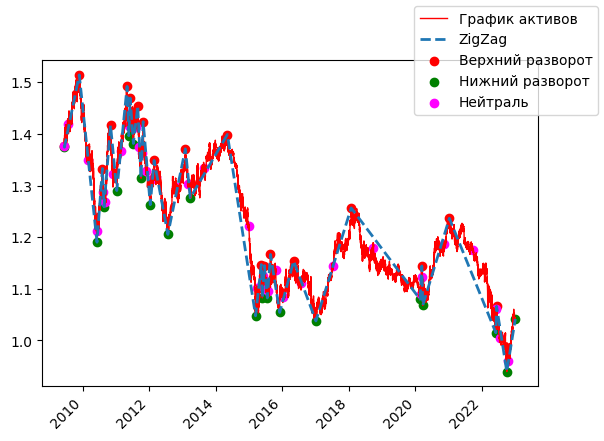

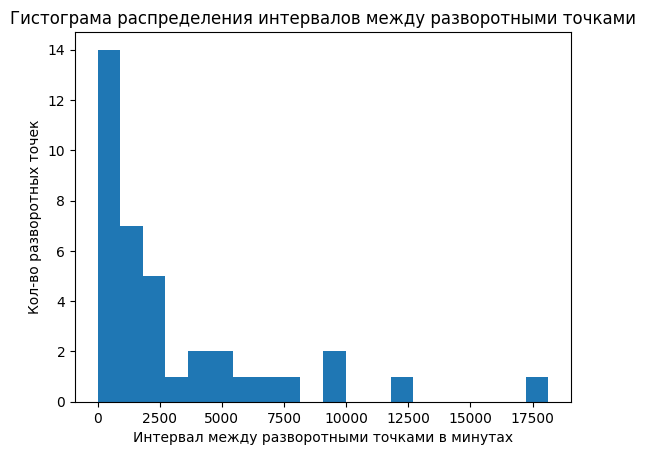

Time history len: 1562m
Count of indicator's point: 77


In [10]:
h_close = 0.05    
dataset = zigzagIndicator(h_close, df_close, True, True)

# Линейная регрессия

Загружаем предысторию и строим линейную регрессию по всем фреймам

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split 

In [12]:
df_prehistory = pd.read_csv('dataset/dataset_close.csv', index_col=0)
df_prehistory_val = df_prehistory.drop(['indicator'],axis=1)
df_prehistory_val

,1,2,3,4,5,6,7,8,9,10,...,1553,1554,1555,1556,1557,1558,1559,1560,1561,1562
0,1.0360,1.0358,1.0361,1.0360,1.0362,1.0363,1.0362,1.0363,1.0362,1.0361,...,1.0414,1.0414,1.0414,1.0416,1.0417,1.0416,1.0417,1.0415,1.0417,1.0417
1,0.9719,0.9718,0.9717,0.9718,0.9718,0.9717,0.9717,0.9717,0.9718,0.9718,...,0.9592,0.9594,0.9592,0.9590,0.9592,0.9593,0.9594,0.9595,0.9594,0.9597
2,0.9563,0.9560,0.9562,0.9563,0.9558,0.9567,0.9570,0.9574,0.9571,0.9570,...,0.9410,0.9405,0.9405,0.9409,0.9407,0.9408,0.9406,0.9406,0.9402,0.9397
3,1.0170,1.0179,1.0174,1.0177,1.0179,1.0173,1.0169,1.0171,1.0170,1.0172,...,1.0043,1.0044,1.0045,1.0049,1.0048,1.0047,1.0048,1.0050,1.0049,1.0045
4,1.0542,1.0559,1.0584,1.0588,1.0583,1.0576,1.0576,1.0578,1.0573,1.0568,...,1.0659,1.0653,1.0651,1.0655,1.0658,1.0658,1.0658,1.0660,1.0658,1.0661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1.1959,1.1951,1.1950,1.1950,1.1940,1.1945,1.1941,1.1941,1.1955,1.1948,...,1.2126,1.2119,1.2118,1.2110,1.2108,1.2110,1.2110,1.2118,1.2118,1.2119
70,1.2184,1.2182,1.2178,1.2177,1.2180,1.2176,1.2176,1.2174,1.2175,1.2173,...,1.1930,1.1927,1.1932,1.1933,1.1927,1.1923,1.1920,1.1910,1.1905,1.1903
71,1.3614,1.3614,1.3616,1.3616,1.3615,1.3612,1.3614,1.3616,1.3613,1.3615,...,1.3497,1.3500,1.3498,1.3497,1.3495,1.3490,1.3488,1.3487,1.3489,1.3486
72,1.4878,1.4872,1.4876,1.4881,1.4879,1.4879,1.4878,1.4877,1.4877,1.4878,...,1.5137,1.5137,1.5139,1.5138,1.5140,1.5140,1.5139,1.5143,1.5143,1.5144


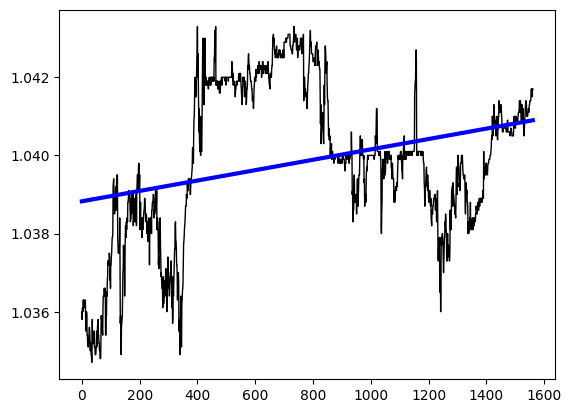

indicator: 1, 
коэффициент наклона: 1.3284872248263182e-06, 
смещение: 1.0388252796134687


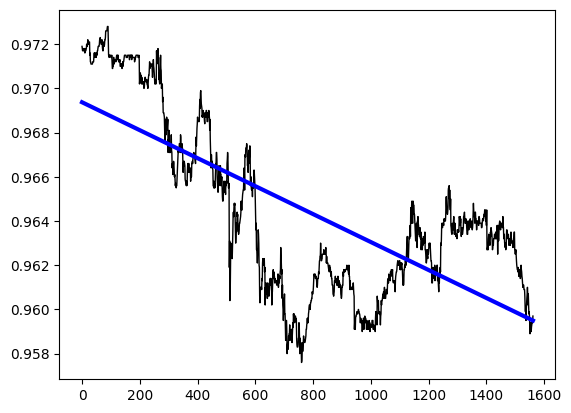

indicator: 0, 
коэффициент наклона: -6.325919725288597e-06, 
смещение: 0.9693728476951396


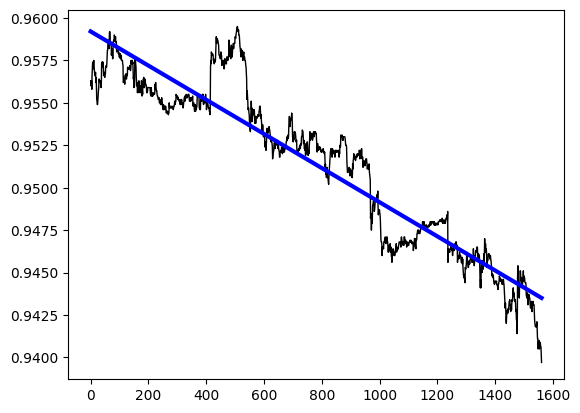

indicator: 1, 
коэффициент наклона: -1.0060133888581794e-05, 
смещение: 0.9592069921184759


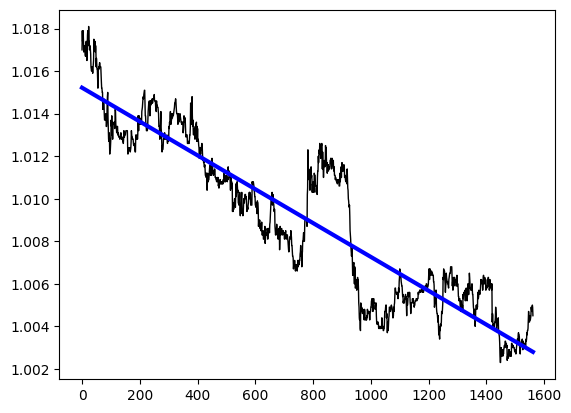

indicator: 0, 
коэффициент наклона: -7.958321574650256e-06, 
смещение: 1.0152215212054037


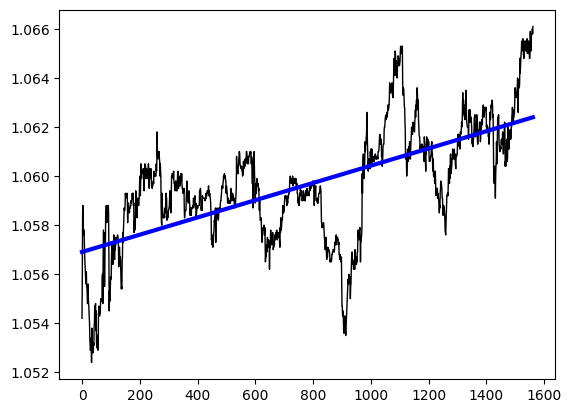

indicator: -1, 
коэффициент наклона: 3.517647469291026e-06, 
смещение: 1.0569064607853018


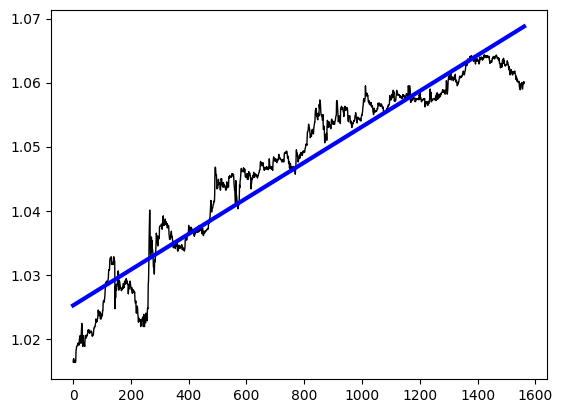

indicator: 0, 
коэффициент наклона: 2.7899075429216375e-05, 
смещение: 1.0252129918579704


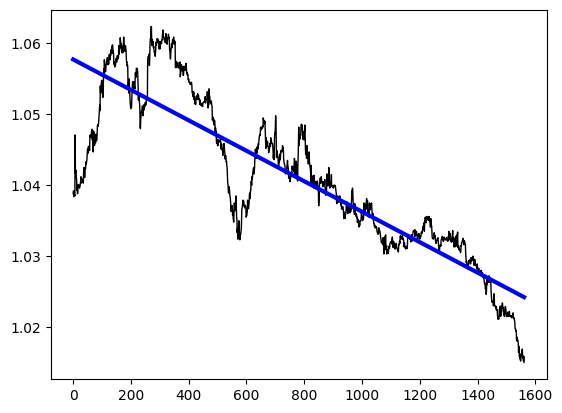

indicator: 1, 
коэффициент наклона: -2.147947941338722e-05, 
смещение: 1.057747960314671


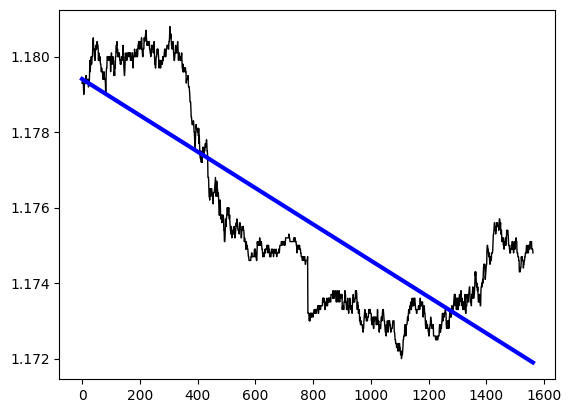

indicator: 0, 
коэффициент наклона: -4.81171679765248e-06, 
смещение: 1.1794081698005165


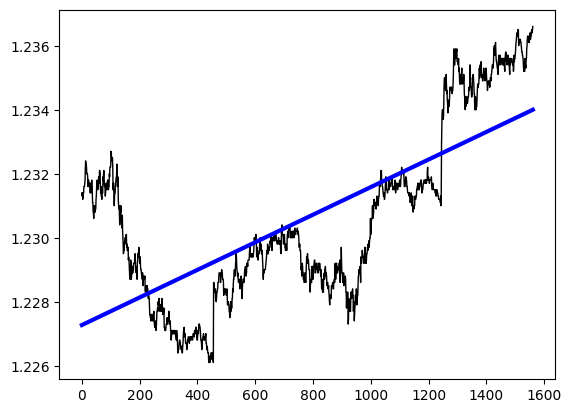

indicator: -1, 
коэффициент наклона: 4.3095220087005684e-06, 
смещение: 1.2272702849095973


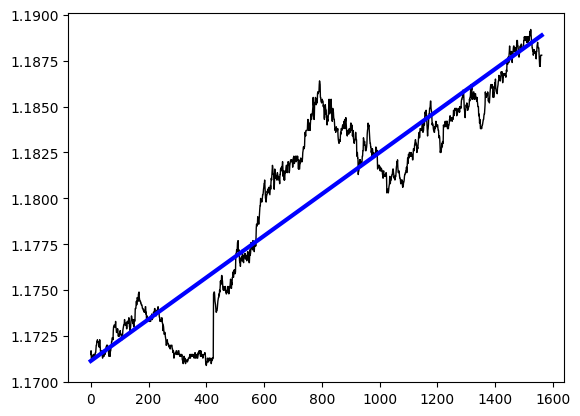

indicator: 0, 
коэффициент наклона: 1.1361334980799804e-05, 
смещение: 1.1711453461652834


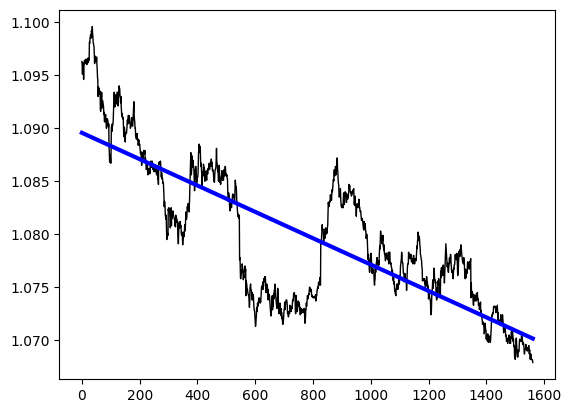

indicator: 1, 
коэффициент наклона: -1.2433359103079881e-05, 
смещение: 1.0895689614918618


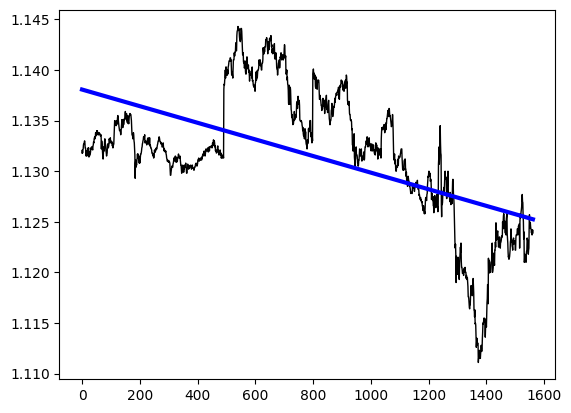

indicator: 0, 
коэффициент наклона: -8.212652185498327e-06, 
смещение: 1.1380694500627917


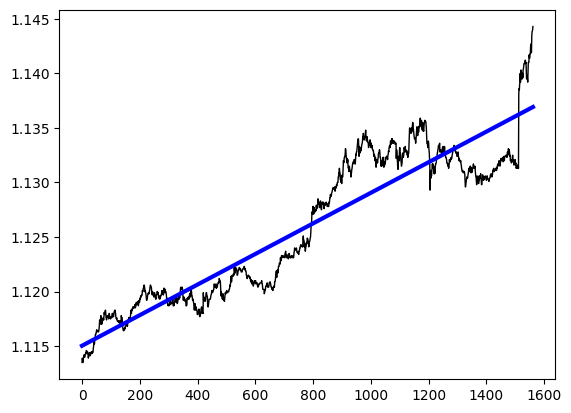

indicator: -1, 
коэффициент наклона: 1.4019385673586382e-05, 
смещение: 1.115034502004173


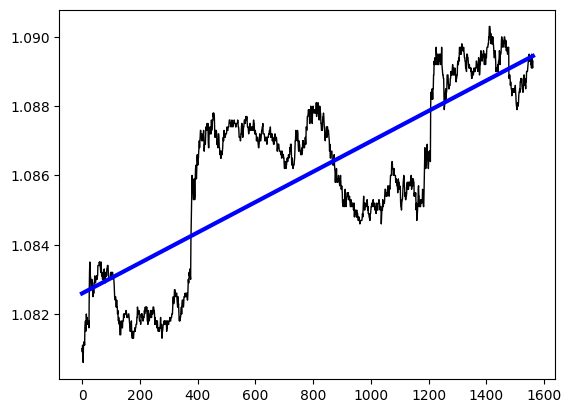

indicator: 0, 
коэффициент наклона: 4.391461014554265e-06, 
смещение: 1.0825936554591904


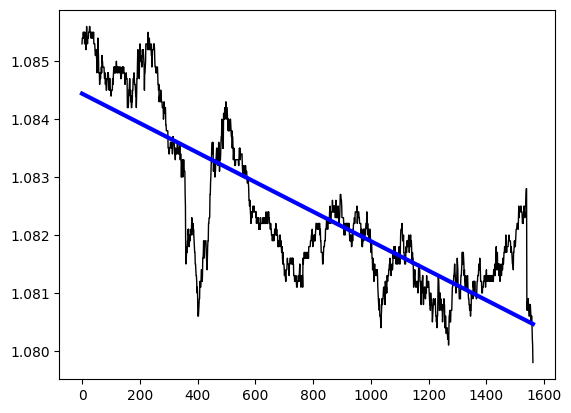

indicator: 1, 
коэффициент наклона: -2.547726797620079e-06, 
смещение: 1.0844413176669507


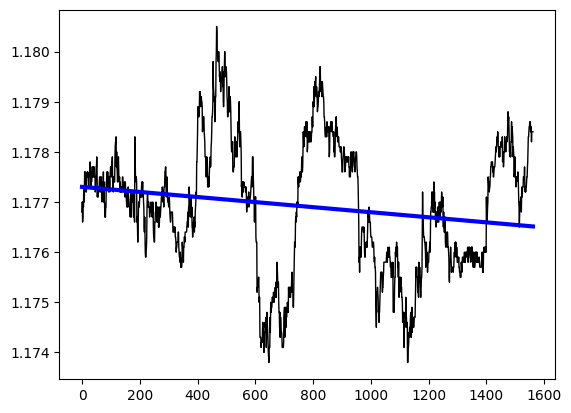

indicator: 0, 
коэффициент наклона: -5.052451416026023e-07, 
смещение: 1.1773013860865418


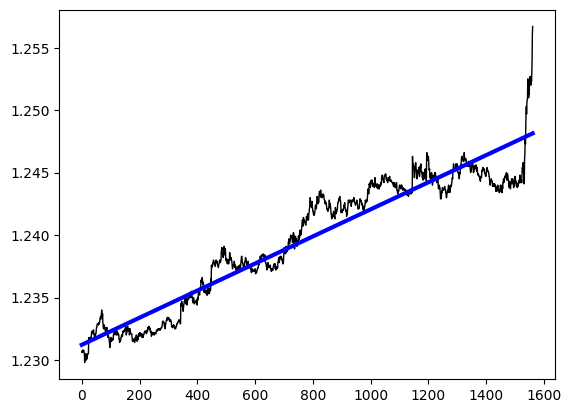

indicator: -1, 
коэффициент наклона: 1.0844441034416952e-05, 
смещение: 1.2312145949506146


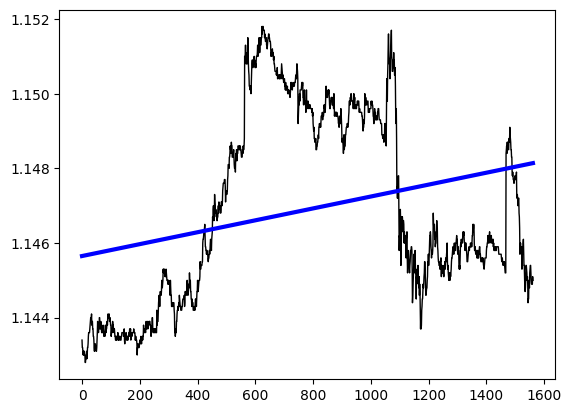

indicator: 0, 
коэффициент наклона: 1.5944623896406559e-06, 
смещение: 1.1456510406708265


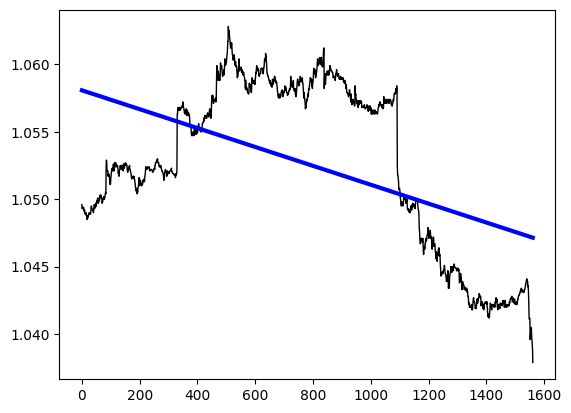

indicator: 1, 
коэффициент наклона: -6.996892927321051e-06, 
смещение: 1.0580688214086473


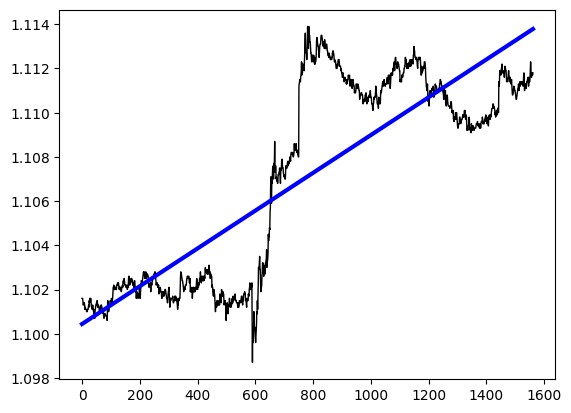

indicator: 0, 
коэффициент наклона: 8.549512035598146e-06, 
смещение: 1.1004393977896343


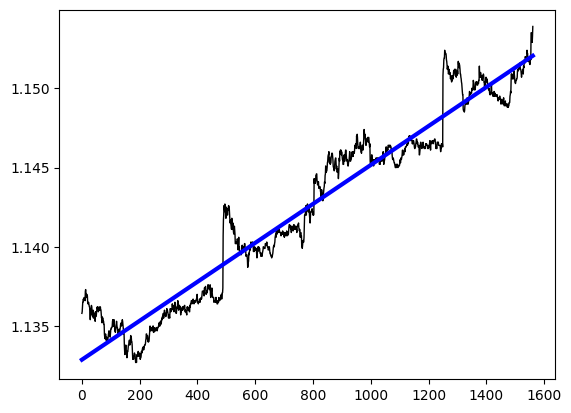

indicator: -1, 
коэффициент наклона: 1.2285139515833006e-05, 
смещение: 1.132874764869096


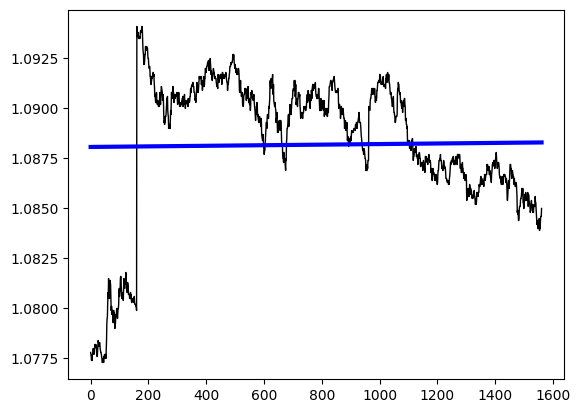

indicator: 0, 
коэффициент наклона: 1.4427719340305878e-07, 
смещение: 1.0880764441473478


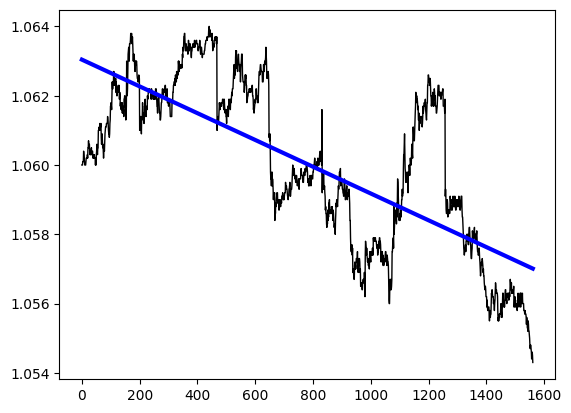

indicator: 1, 
коэффициент наклона: -3.864669598765858e-06, 
смещение: 1.0630429431237574


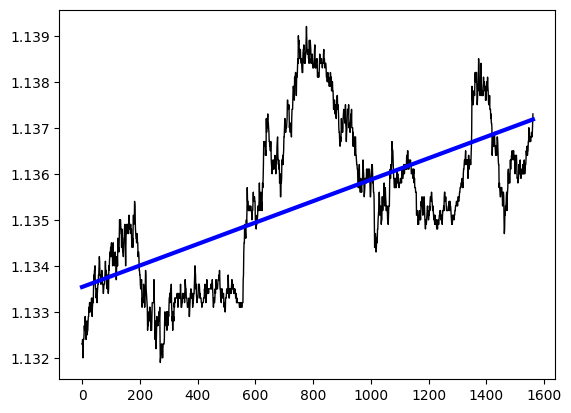

indicator: 0, 
коэффициент наклона: 2.3326212815766252e-06, 
смещение: 1.1335394403061188


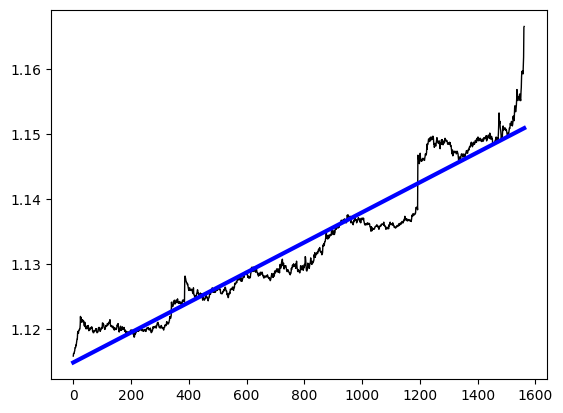

indicator: -1, 
коэффициент наклона: 2.30912832349638e-05, 
смещение: 1.114915409645098


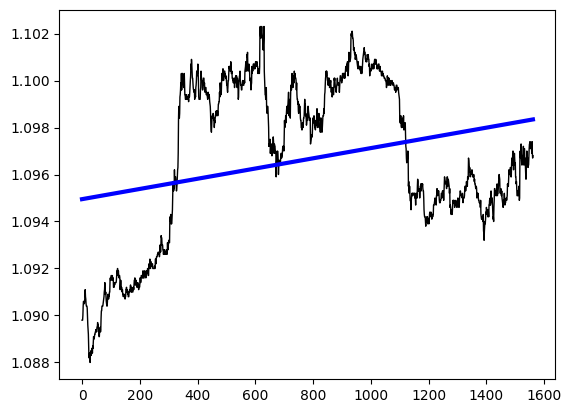

indicator: 0, 
коэффициент наклона: 2.1738267711200484e-06, 
смещение: 1.0949503832627592


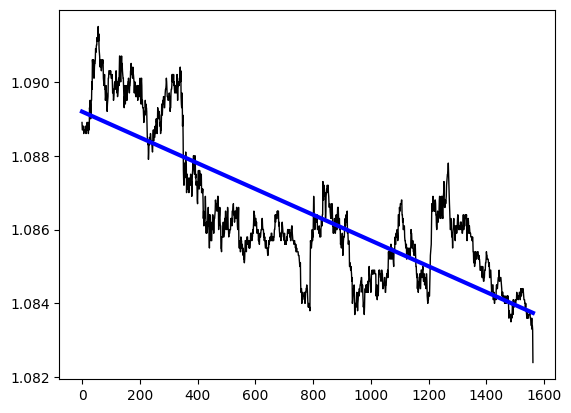

indicator: 1, 
коэффициент наклона: -3.49239165140693e-06, 
смещение: 1.0891949538094032


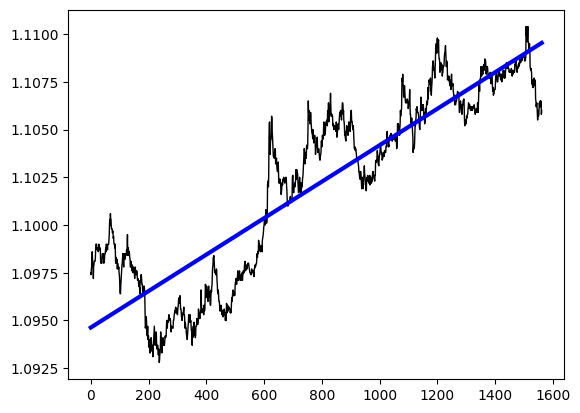

indicator: 0, 
коэффициент наклона: 9.551518953527184e-06, 
смещение: 1.0946298025809718


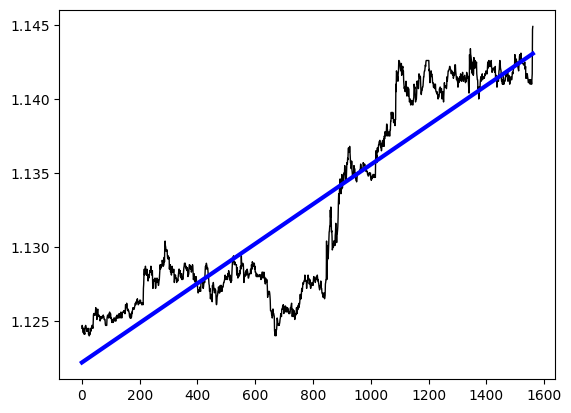

indicator: -1, 
коэффициент наклона: 1.336952374577209e-05, 
смещение: 1.122194344078781


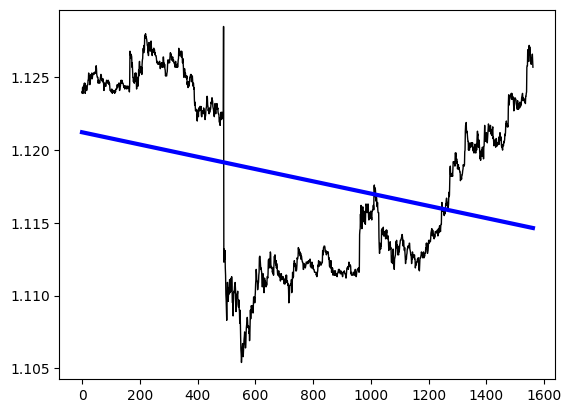

indicator: 0, 
коэффициент наклона: -4.217969708230174e-06, 
смещение: 1.1212290011575299


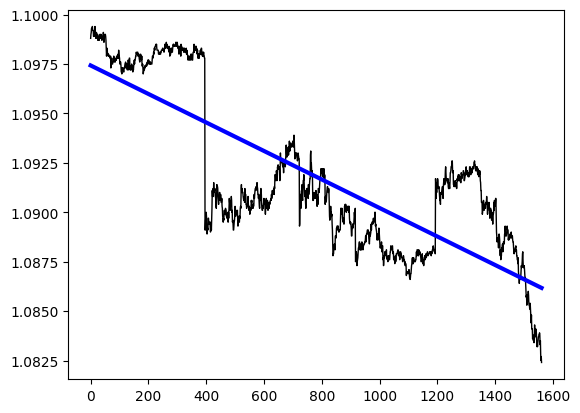

indicator: 1, 
коэффициент наклона: -7.210488302325814e-06, 
смещение: 1.097428298283858


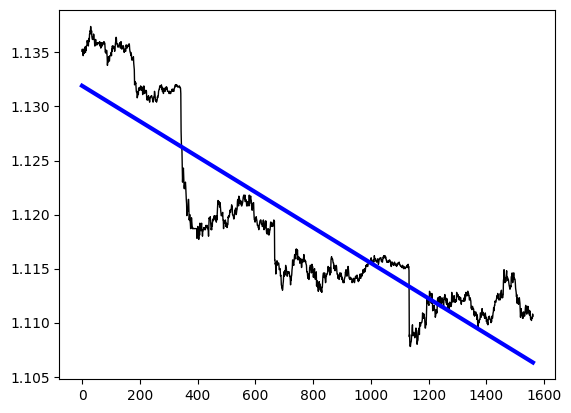

indicator: 0, 
коэффициент наклона: -1.6400261881001143e-05, 
смещение: 1.1319162174583006


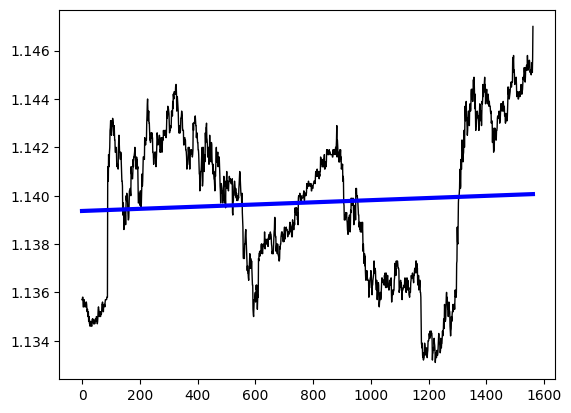

indicator: -1, 
коэффициент наклона: 4.4744745317288665e-07, 
смещение: 1.1393672205278433


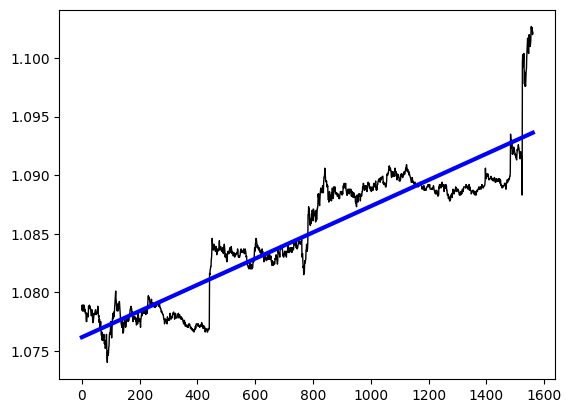

indicator: 0, 
коэффициент наклона: 1.1188624722191784e-05, 
смещение: 1.0761583795566978


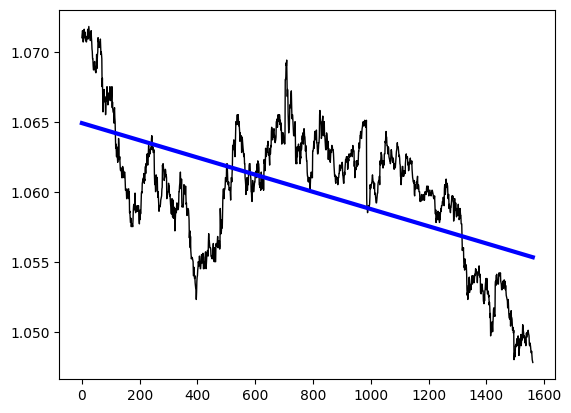

indicator: 1, 
коэффициент наклона: -6.138302176800437e-06, 
смещение: 1.064898691327866


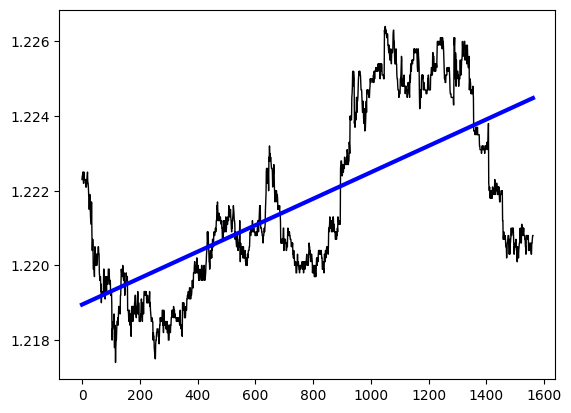

indicator: 0, 
коэффициент наклона: 3.543807451060141e-06, 
смещение: 1.218950127426573


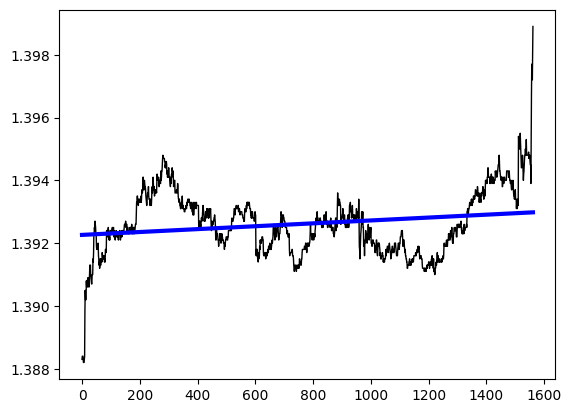

indicator: -1, 
коэффициент наклона: 4.6023264223349706e-07, 
смещение: 1.3922627474496252


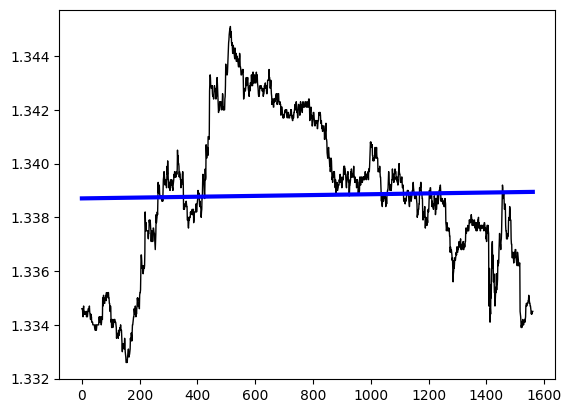

indicator: 0, 
коэффициент наклона: 1.551808462300286e-07, 
смещение: 1.3387042334621937


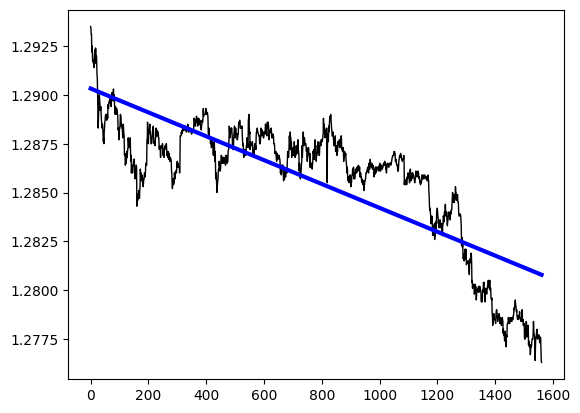

indicator: 1, 
коэффициент наклона: -6.107795501543315e-06, 
смещение: 1.2903236644785832


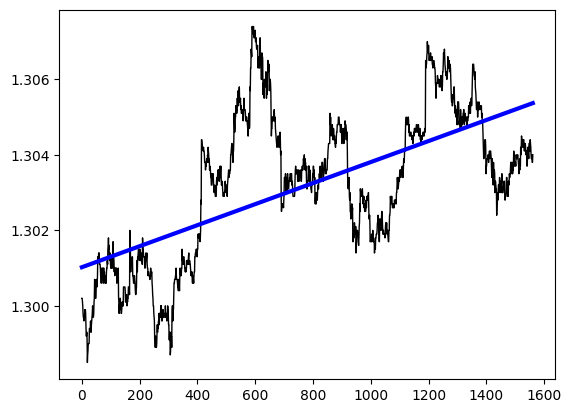

indicator: 0, 
коэффициент наклона: 2.7846808679572272e-06, 
смещение: 1.3010233555582316


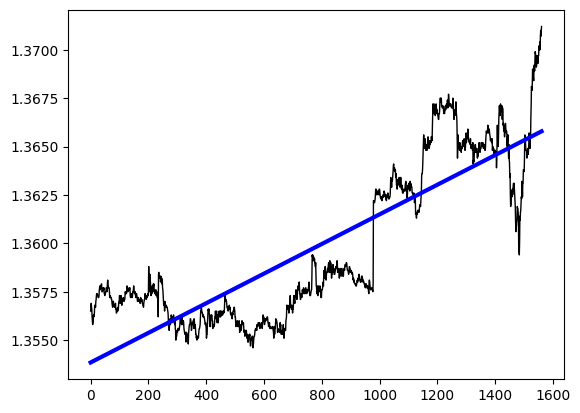

indicator: -1, 
коэффициент наклона: 7.648734317528931e-06, 
смещение: 1.3538439912902647


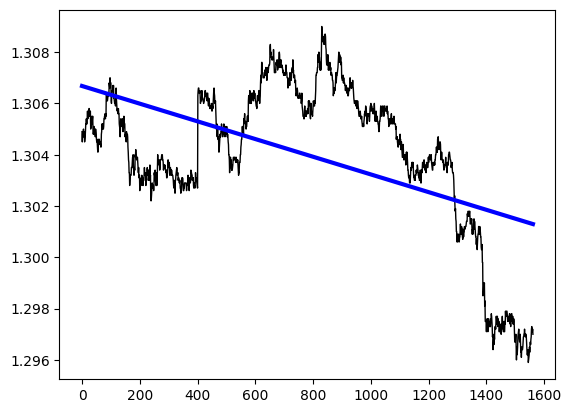

indicator: 0, 
коэффициент наклона: -3.449142137791754e-06, 
смещение: 1.3066802116485339


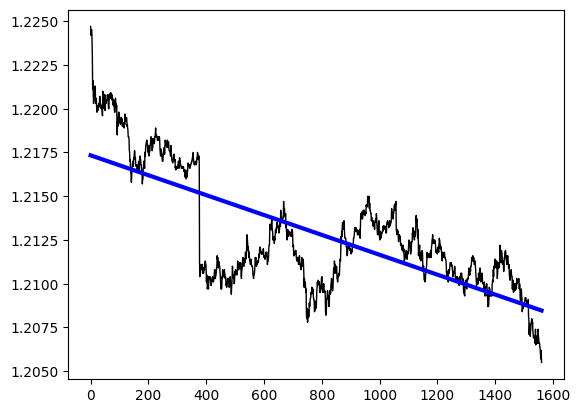

indicator: 1, 
коэффициент наклона: -5.680079067533744e-06, 
смещение: 1.2173363746955645


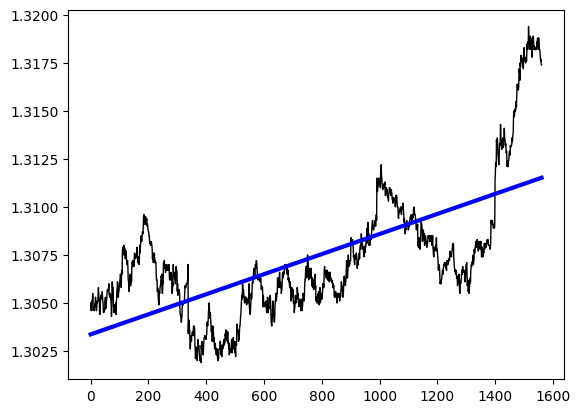

indicator: 0, 
коэффициент наклона: 5.225773476976993e-06, 
смещение: 1.3033637934042923


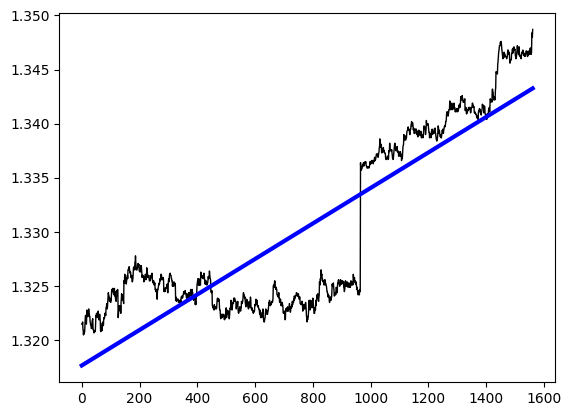

indicator: -1, 
коэффициент наклона: 1.6388196968759933e-05, 
смещение: 1.317680587169852


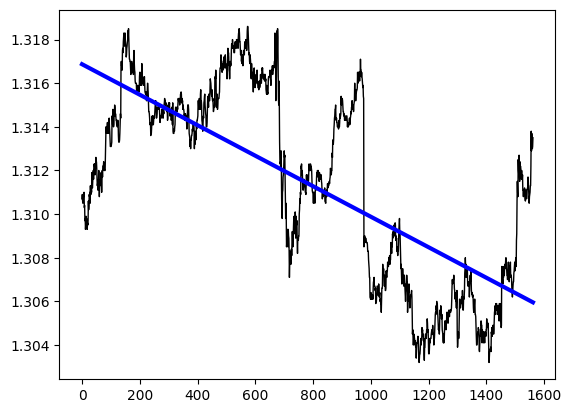

indicator: 0, 
коэффициент наклона: -6.991779198059411e-06, 
смещение: 1.3168707840482083


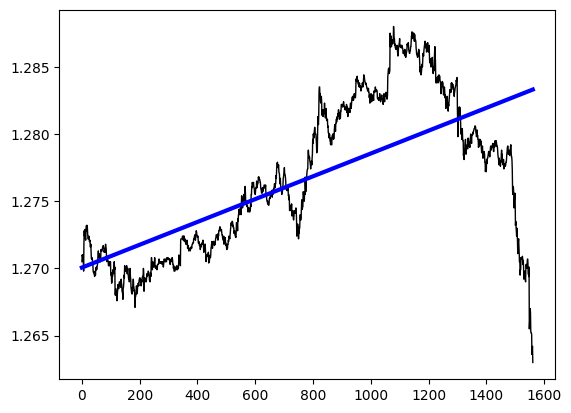

indicator: 1, 
коэффициент наклона: 8.485282235811539e-06, 
смещение: 1.270062128380122


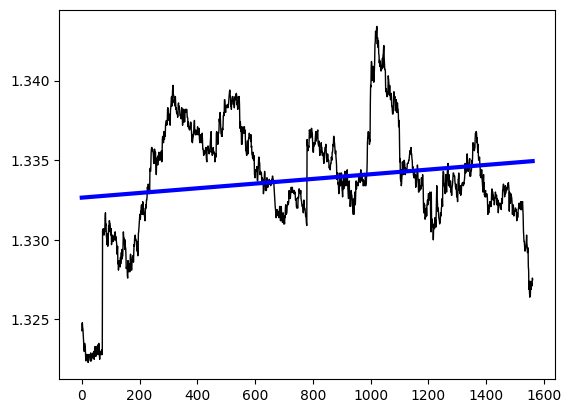

indicator: 0, 
коэффициент наклона: 1.468992056946248e-06, 
смещение: 1.3326514670644702


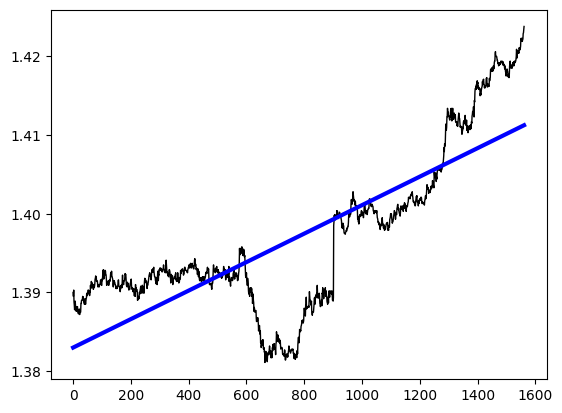

indicator: -1, 
коэффициент наклона: 1.8101388687252924e-05, 
смещение: 1.3829940172179473


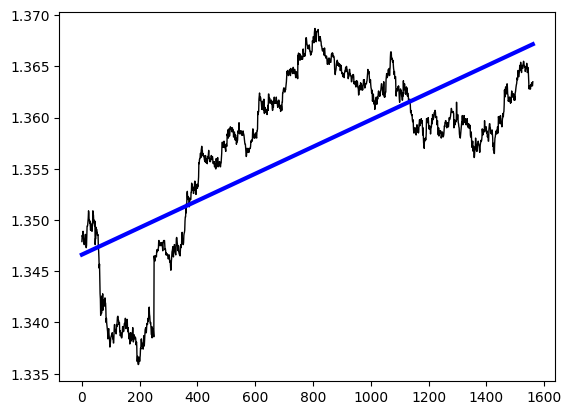

indicator: 0, 
коэффициент наклона: 1.315844327828942e-05, 
смещение: 1.3466231768906929


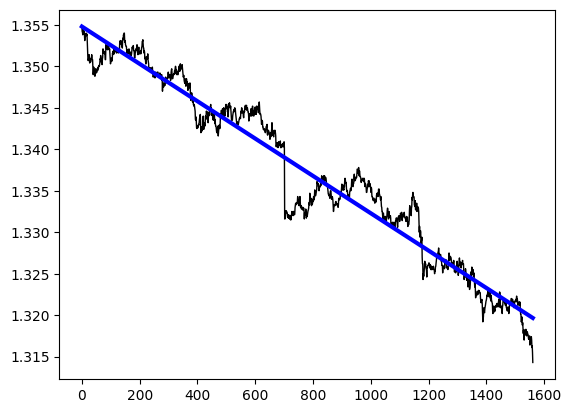

indicator: 1, 
коэффициент наклона: -2.2503128170098657e-05, 
смещение: 1.3547923086942528


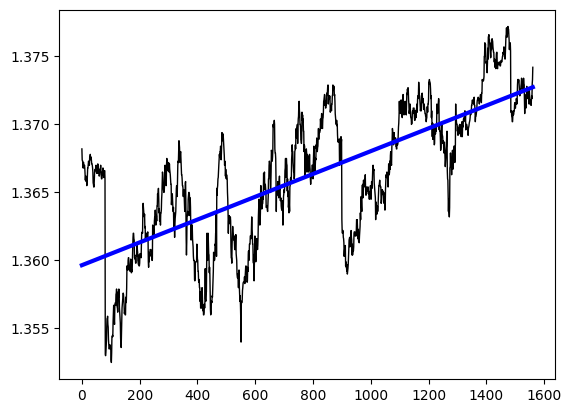

indicator: 0, 
коэффициент наклона: 8.382527308595008e-06, 
смещение: 1.3596510994074726


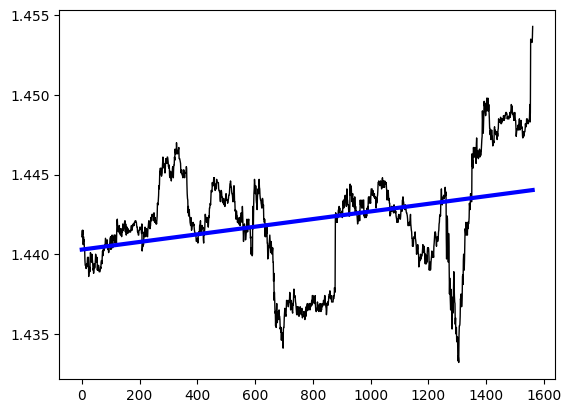

indicator: -1, 
коэффициент наклона: 2.3951208426210375e-06, 
смещение: 1.4402893789889923


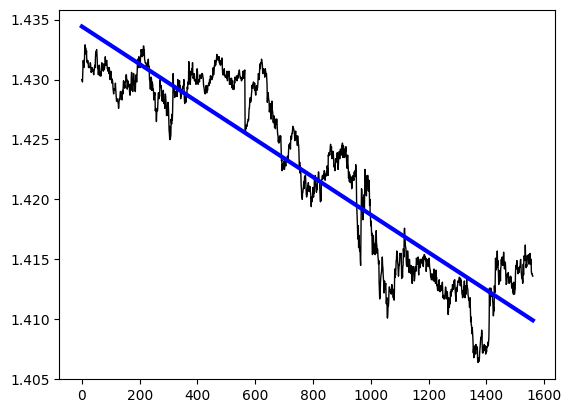

indicator: 0, 
коэффициент наклона: -1.5699971759323488e-05, 
смещение: 1.4344268753333118


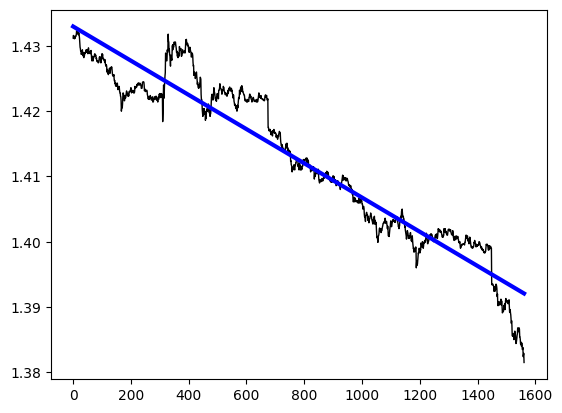

indicator: 1, 
коэффициент наклона: -2.6205059762501236e-05, 
смещение: 1.4329748801305475


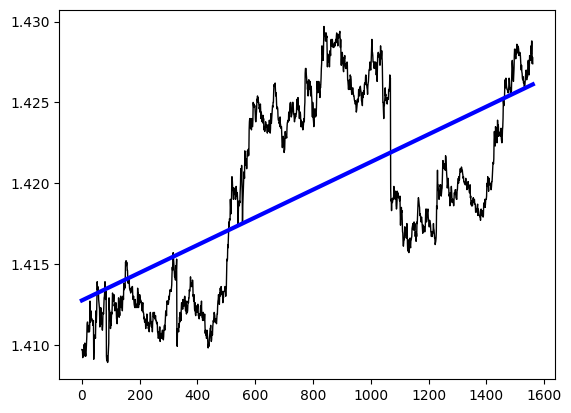

indicator: 0, 
коэффициент наклона: 8.567949862675168e-06, 
смещение: 1.4127417804330782


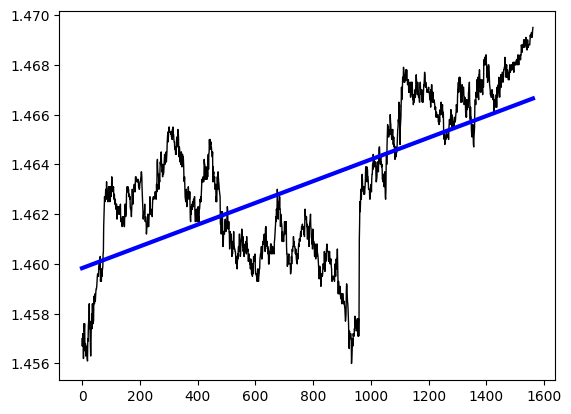

indicator: -1, 
коэффициент наклона: 4.367783980483382e-06, 
смещение: 1.459829676997599


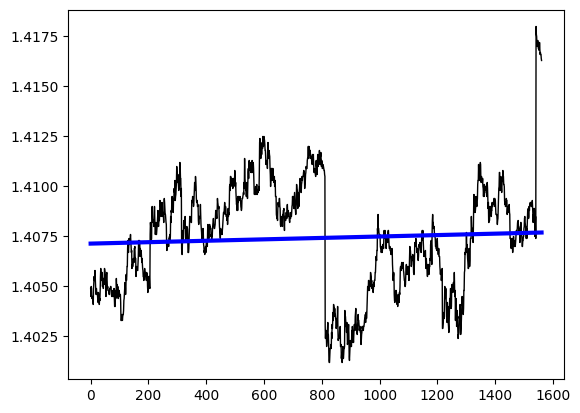

indicator: 0, 
коэффициент наклона: 3.5500374125949215e-07, 
смещение: 1.407143662217591


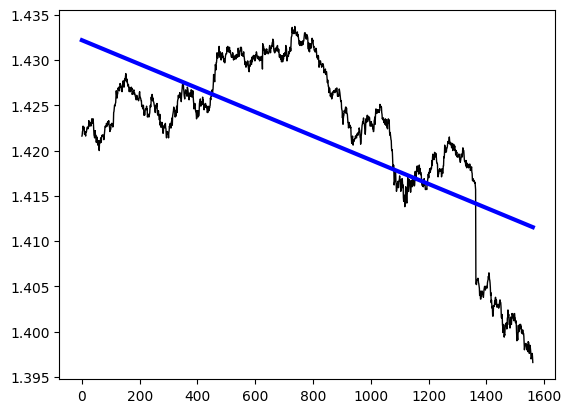

indicator: 1, 
коэффициент наклона: -1.3225982730381642e-05, 
смещение: 1.432185235474968


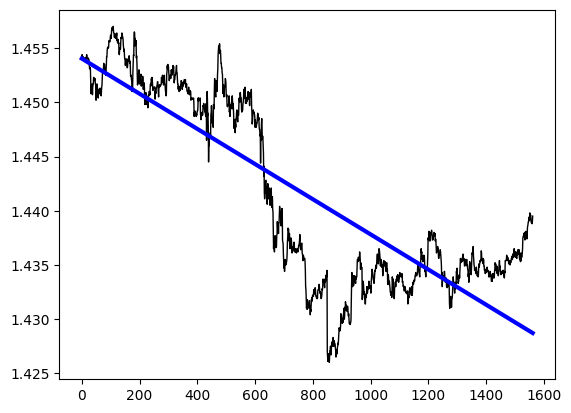

indicator: 0, 
коэффициент наклона: -1.6221941964829613e-05, 
смещение: 1.4540399709020129


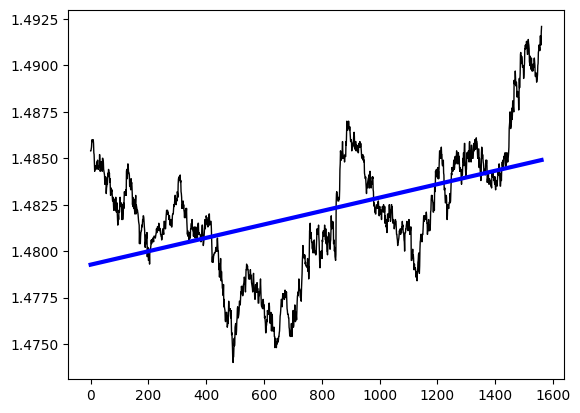

indicator: -1, 
коэффициент наклона: 3.611949101804659e-06, 
смещение: 1.4792689659155422


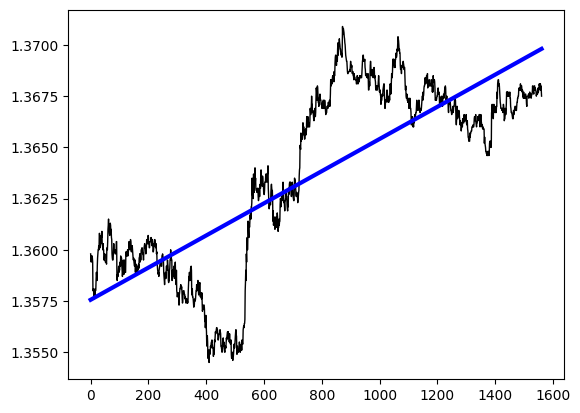

indicator: 0, 
коэффициент наклона: 7.846575546038975e-06, 
смещение: 1.357559806685164


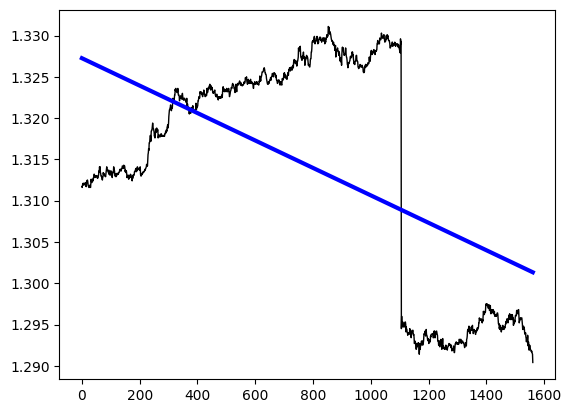

indicator: 1, 
коэффициент наклона: -1.661342461760161e-05, 
смещение: 1.3272588393737055


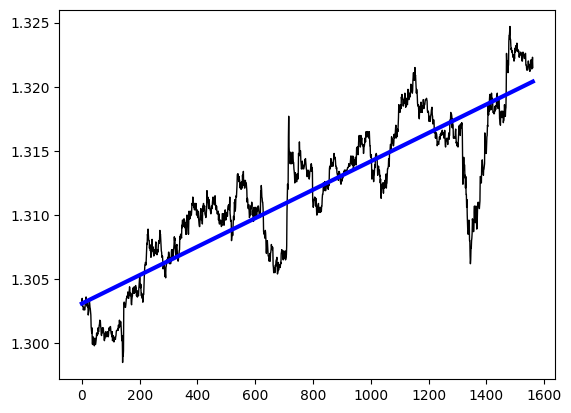

indicator: 0, 
коэффициент наклона: 1.1086883063086713e-05, 
смещение: 1.303096495707801


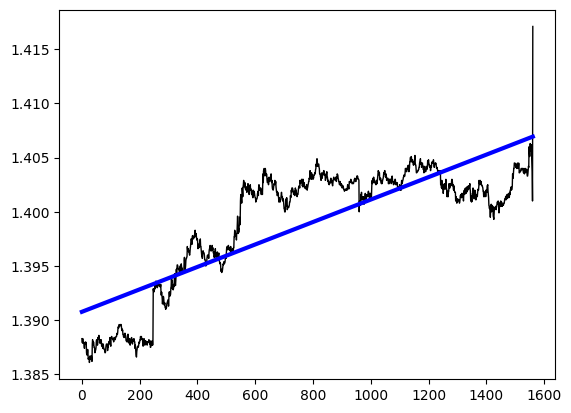

indicator: -1, 
коэффициент наклона: 1.0355380788462746e-05, 
смещение: 1.3907742834252066


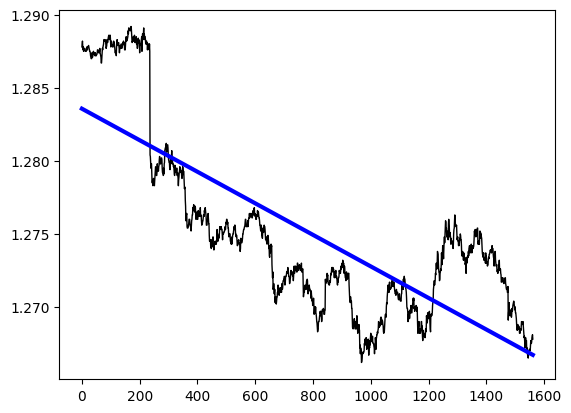

indicator: 0, 
коэффициент наклона: -1.0796286396302061e-05, 
смещение: 1.2835732364874994


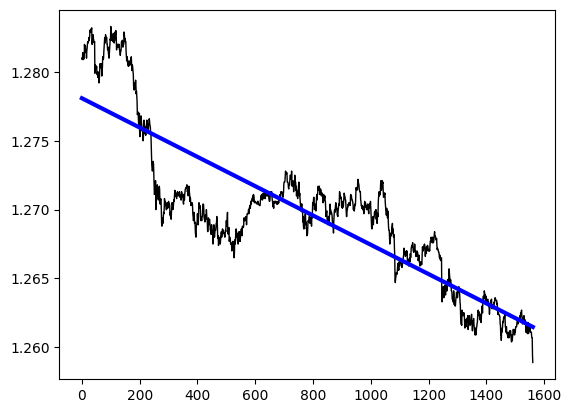

indicator: 1, 
коэффициент наклона: -1.0638843014952434e-05, 
смещение: 1.2780883160768834


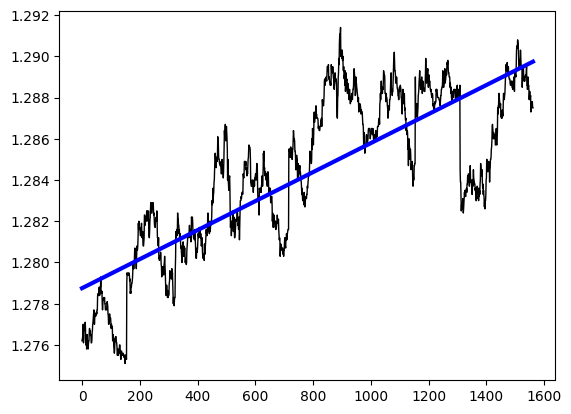

indicator: 0, 
коэффициент наклона: 7.039933363861623e-06, 
смещение: 1.2787520669646917


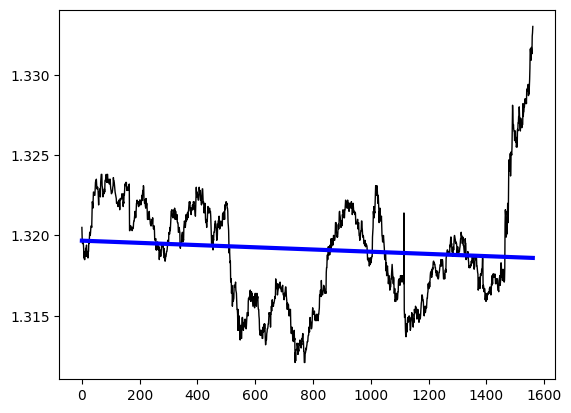

indicator: -1, 
коэффициент наклона: -6.875294928757962e-07, 
смещение: 1.319677205757666


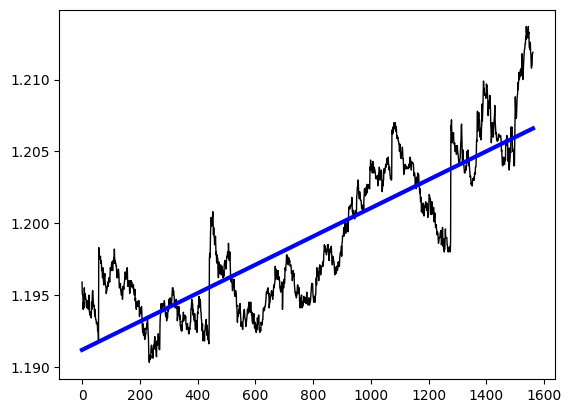

indicator: 0, 
коэффициент наклона: 9.87985167071026e-06, 
смещение: 1.1911768039400248


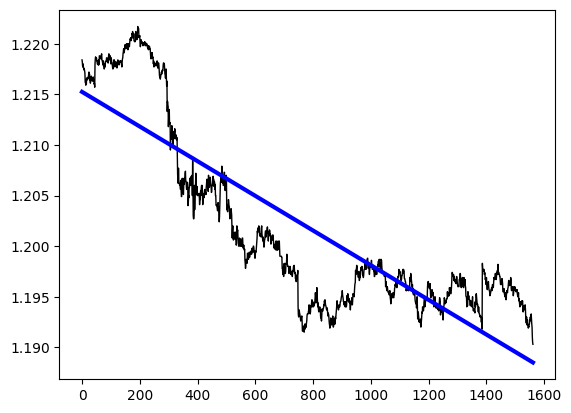

indicator: 1, 
коэффициент наклона: -1.712744375420897e-05, 
смещение: 1.21524120928678


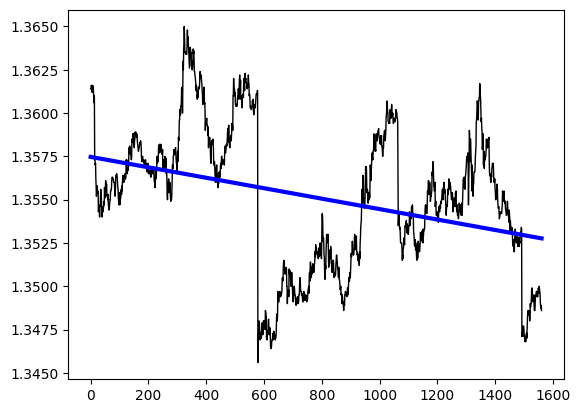

indicator: 0, 
коэффициент наклона: -3.0138313883857136e-06, 
смещение: 1.357470157114384


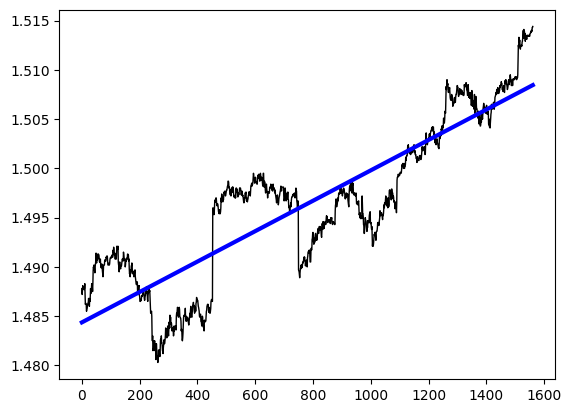

indicator: -1, 
коэффициент наклона: 1.542681791426092e-05, 
смещение: 1.4843699319982009


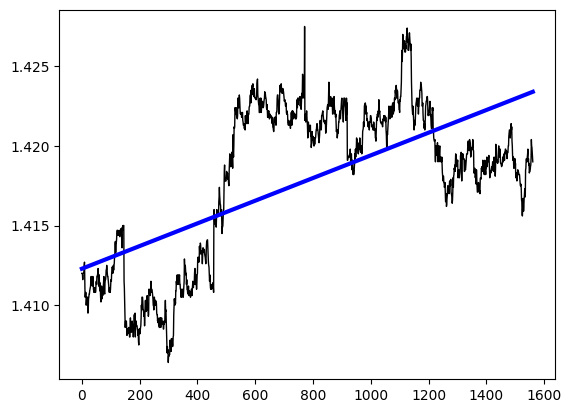

indicator: 0, 
коэффициент наклона: 7.117796311386359e-06, 
смещение: 1.4122878378278743


In [13]:
for i in range(df_prehistory_val.shape[0]):
    batch = pd.DataFrame({'num':np.arange(0,len(df_prehistory_val.iloc[i])), 
                          'val':df_prehistory_val.iloc[i].values})
    
    lr = LinearRegression()
    lr.fit(batch.num.values.reshape(-1,1), batch.val)
    pred = lr.predict(batch.num.values.reshape(-1,1))
    
    plt.plot(batch.num, batch.val, color="black", linewidth=1)
    plt.plot(batch.num, pred, color="blue", linewidth=3)
    plt.show()
    print(f"indicator: {df_prehistory.indicator.iloc[i]}, \nкоэффициент наклона: {lr.coef_[0]}, \nсмещение: {lr.intercept_}")

In [14]:
index = 2
test = pd.DataFrame({'num':np.arange(0,len(df_prehistory_val.iloc[index])), 'val':df_prehistory_val.iloc[index].values})
test

,num,val
0,0,0.9563
1,1,0.9560
2,2,0.9562
3,3,0.9563
4,4,0.9558
...,...,...
1557,1557,0.9408
1558,1558,0.9406
1559,1559,0.9406
1560,1560,0.9402


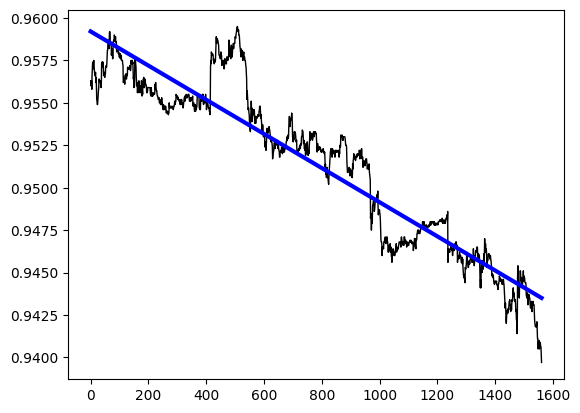

indicator: 1, 
коэффициент наклона: -1.0060133888581794e-05, 
смещение: 0.9592069921184759


In [15]:
lr = LinearRegression()
lr.fit(test.num.values.reshape(-1,1), test.val)
pred = lr.predict(test.num.values.reshape(-1,1))
plt.plot(test.num, test.val, color="black", linewidth=1)
plt.plot(test.num, pred, color="blue", linewidth=3)
plt.show()
print(f"indicator: {df_prehistory.indicator.iloc[index]}, \nкоэффициент наклона: {lr.coef_[0]}, \nсмещение: {lr.intercept_}")